# Алгоритмы анализа данных

## Урок 7. Классификация с помощью KNN. Кластеризация K-means

## <center> Практическое задание </center>

__Задание 1:__ К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей в зависимости от номера соседа.

__Задание 2:__ К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей в зависимости от расстояния до соседа. Сравнить метрики качества и сложность разделяющей гиперплоскости. Сделать выводы.

__Задание 3:__ Настроить оптимальное значение числа соседей для моделей из п.1 и п.2, __сделать выводы__.

__Задание 4 (опция):__ Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутриклассовое расстояние и построить график ее зависимости от количества кластеров k (взять от 1 до 10) для выборки данных из данного урока (создать датасет, как в методичке).

In [1]:
import random
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
#Генерируем датасет
def generateData_1(numberOfClassEl, numberOfClasses):
    data = []
    label = []
    for classNum in range(numberOfClasses):
        #Choose random center of 2-dimensional gaussian
        centerX, centerY = random.random()*5.0, random.random()*5.0
        #Choose numberOfClassEl random nodes with RMS=0.5
        for rowNum in range(numberOfClassEl):
            data.append([random.gauss(centerX,0.5), random.gauss(centerY,0.5)])
            label.append(classNum)
    return data, label

In [3]:
X, y =  generateData_1(100, 4)
X = np.array(X)
y = np.array(y)

Загрузим один из датасетов из sklearn.

In [4]:
# Находим минимальное и максимальное значение для каждого признака
def dataset_minmax(dataset):
    minmax = list()
    for i in range(len(dataset[0])):
        col_values = [row[i] for row in dataset]
        value_min = min(col_values)
        value_max = max(col_values)
        minmax.append([value_min, value_max])

    return minmax

# Нормализация датасета (0-1)
def normalize_dataset(dataset, minmax):
    for row in dataset:
        for i in range(len(row)):
            row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])          


In [5]:
# X, y = load_iris(return_X_y=True)
# Для наглядности возьмем только первые два признака (всего в датасете их 4)
#X = X[:, :2]

Для выполнения практического задания необходимо отмасштабировать признаки.<br />
Применим метод нормализации признаков.

In [6]:
# Находим минимальное и максимальное значение для каждого признака
minmax = dataset_minmax(X)

# Нормализация датасета (0-1)
normalize_dataset(X, minmax)

Разделим выборку на обучающую и тестовую

In [7]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

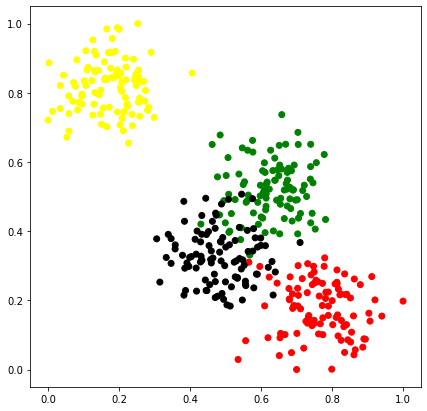

In [8]:
cmap = ListedColormap(['red', 'green', 'blue', 'yellow', 'black'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)

Используем евклидову метрику. Реализуем функцию для ее подсчета.

In [9]:
def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
      
    return np.sqrt(distance)

Реализуем алгоритм поиска k ближайших соседей.

In [10]:
def knn(x_train, y_train, x_test, k):
    # Базовый алгоритм (вариант из методички), без взвешивания.
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += 1
            
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

Функция для вычисления точности

In [11]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [12]:
def get_graph(X_train, y_train, k, q: 0.1, algorism):
    """
    Строим график распределения классов.
    
    """
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF','#FFAA00'])

    h = .02

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Получим предсказания для всех точек
    if algorism == 0:
        # Без взвешивания
        Z = knn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k)
    if algorism == 1:    
        # Взвешивание по индексам
        Z = knn_wi(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k, q)
    if algorism == 2:
        # Взвешивание по расстоянию
        Z = knn_wn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k, q)

    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()

Проверим работу алгоритма при различных k

In [28]:
k = 5
y_pred = knn(X_train, y_train, X_test, k)
print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')
print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test)}')

Точность алгоритма при k = 5: 0.938
Точность алгоритма при k = 5: 0.9375


Построим график распределения классов.

<ipython-input-12-ddb2c92b3541>:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


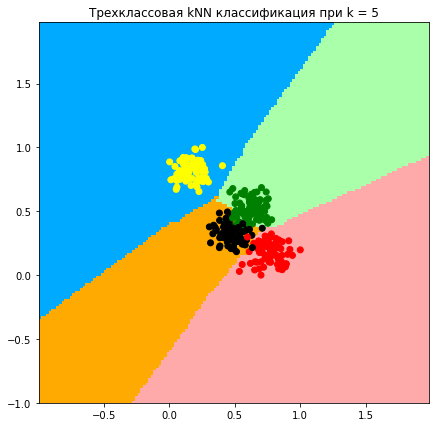

In [14]:
algorism = 0
q = 0.5
get_graph(X_train, y_train, k, q, algorism)

### 1. Задача:

- К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей в зависимости от номера соседа.

Создаём функцию вычисляющую вес зависящий от номера соседа i и основания q (q - гиперпараметр).

In [15]:
def weight_ni(i, q):
    """
    Вычисление весов для соседей в зависимости от номера i соседа

    Parameters
    ----------
    i: int
        Номер соседа.

    q: float
        Основание для вычисления весов 0 < q < 1.

    Returns
    -------
    w: float
        Значение веса.

    """
    if i == 0:
        i = 0.9  # Чтоб не создавать слишком больших весов.
                 # Если этого не сделать качество модели резко падает.

    w = q**i
    
    return w

In [16]:
q=0.5
print(weight_ni(0, q))
print(weight_ni(1, q))
print(weight_ni(2, q))

0.5358867312681466
0.5
0.25


Реализуем алгоритм поиска k ближайших соседей с учётом весов зависящих от номера соседа.

In [17]:
def knn_wi(x_train, y_train, x_test, k, q):
    """
    Реализуем алгоритм поиска k ближайших соседей с учётом весов зависящих от номера соседа.

    Parameters
    ----------
    k: int
        Количество ближайших соседей.

    q: float
        Основание для вычисления весов 0 < q < 1.

    Returns
    -------
    answers: list
        Список ответов.

    """
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
                    
        # создаем словарь со всеми возможными классами (создаём множество из y_train)
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        
        test_distances_sort = sorted(test_distances)[0:k]
        #print(test_distances_sort)
        # [(0.08784104611578843, 0), (0.1672443691498929, 2), ..., (0.18685588954269042, 1)]
        for i in range(len(test_distances_sort)):

            #
            # Изменение базового алгоритма:
            #
            # Присваиваем классам веса зависящие от номера соседа
            #
            # classes[d[1]] += 1
            #
            # print(i, test_distances_sort[i])
            classes[test_distances_sort[i][1]] += weight_ni(i, q)

        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        j = 0
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += weight_ni(j, q)
            
        # Записываем в список ответов класс c наибольшим весом
        answers.append(sorted(classes, key=classes.get)[-1])
        
        # print(classes)
        
    return answers

Проверим работу алгоритма при различных k

In [18]:
k = 5
q = 0.5 
y_pred = knn_wi(X_train, y_train, X_test, k, q)
print(f'q = {q}. Точность алгоритма при k = {k}: {accuracy(y_pred, y_test)}')
#print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

q = 0.5. Точность алгоритма при k = 5: 0.9375


<ipython-input-12-ddb2c92b3541>:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


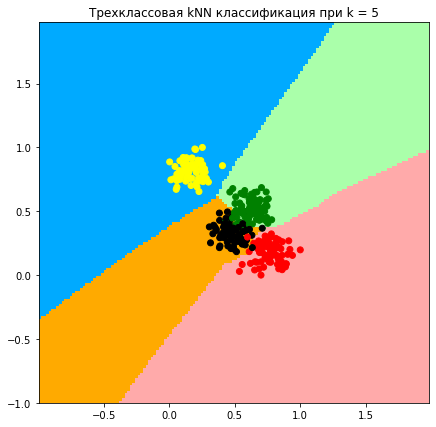

In [19]:
# get_graph_wi(X_train, y_train, k, q)
algorism = 1
get_graph(X_train, y_train, k, q, algorism)

# 

### 2. Задача:

- К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей в зависимости от расстояния до соседа. Сравнить метрики качества и сложность разделяющей гиперплоскости. Сделать выводы.

In [20]:
def weight_nd(distance, q):
    """
    Вычисление весов для соседей в зависимости от дистанции до соседа

    Parameters
    ----------
    distance: float
        Дистанция до соседа.

    q: float
        Основание для вычисления весов 0 < q < 1.

    Returns
    -------
    w: float
        Значение веса.

    """
    w = q**distance
    return w

In [21]:
def knn_wn(x_train, y_train, x_test, k, q):
    """
    Реализуем алгоритм поиска k ближайших соседей с учётом весов зависящих от расстояния до соседа.

    Parameters
    ----------
    k: int
        Количество ближайших соседей.

    q: float
        Основание для вычисления весов 0 < q < 1.

    Returns
    -------
    answers: list
        Список ответов.

    """
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
                    
        # создаем словарь со всеми возможными классами (создаём множество из y_train)
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # print(sorted(test_distances)[0:k])
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:

            #
            # Изменение базового алгоритма:
            #
            # Присваиваем классам веса зависящие от расстояния до соседа
            #
            # classes[d[1]] += 1
            #
            classes[d[1]] += weight_nd(d[0], q)
            
            
        # Записываем в список ответов класс c наибольшим весом
        answers.append(sorted(classes, key=classes.get)[-1])
        
        # print(classes)
        
    return answers

In [31]:
k = 2
q = 0.5 
y_pred = knn_wn(X_train, y_train, X_test, k, q)
print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')
print(f'q = {q}. Точность алгоритма при k = {k}: {accuracy(y_pred, y_test)}')    

Точность алгоритма при k = 2: 0.963
q = 0.5. Точность алгоритма при k = 2: 0.9625


<ipython-input-12-ddb2c92b3541>:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


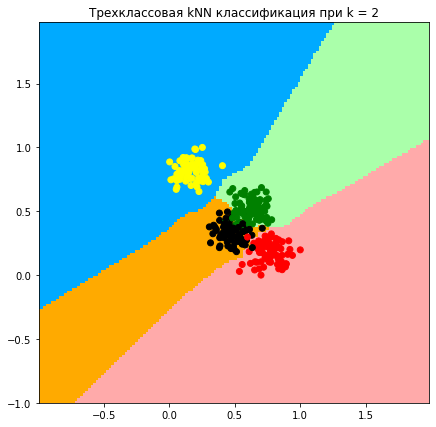

In [32]:
# get_graph_wn(X_train, y_train, k, q)
algorism = 2
get_graph(X_train, y_train, k, q, algorism)

# Задание 3:
    
- Настроить оптимальное значение числа соседей для моделей из п.1 и п.2, сделать выводы.

In [29]:
q = 0.5 
k_accuracy = []

for k in range(1, 30, 1):
    y_pred = knn_wi(X_train, y_train, X_test, k, q)
    k_accuracy.append((k, y_pred))
    print(f'q = {q}. Точность алгоритма при k = {k}: {accuracy(y_pred, y_test)}')    

#k_accuracy

q = 0.5. Точность алгоритма при k = 1: 0.9625
q = 0.5. Точность алгоритма при k = 2: 0.9625
q = 0.5. Точность алгоритма при k = 3: 0.9375
q = 0.5. Точность алгоритма при k = 4: 0.9375
q = 0.5. Точность алгоритма при k = 5: 0.9375
q = 0.5. Точность алгоритма при k = 6: 0.9375
q = 0.5. Точность алгоритма при k = 7: 0.925
q = 0.5. Точность алгоритма при k = 8: 0.925
q = 0.5. Точность алгоритма при k = 9: 0.9375
q = 0.5. Точность алгоритма при k = 10: 0.9125
q = 0.5. Точность алгоритма при k = 11: 0.9125
q = 0.5. Точность алгоритма при k = 12: 0.9125
q = 0.5. Точность алгоритма при k = 13: 0.9125
q = 0.5. Точность алгоритма при k = 14: 0.9125
q = 0.5. Точность алгоритма при k = 15: 0.925
q = 0.5. Точность алгоритма при k = 16: 0.925
q = 0.5. Точность алгоритма при k = 17: 0.925
q = 0.5. Точность алгоритма при k = 18: 0.9375
q = 0.5. Точность алгоритма при k = 19: 0.9375
q = 0.5. Точность алгоритма при k = 20: 0.9375
q = 0.5. Точность алгоритма при k = 21: 0.925
q = 0.5. Точность алгоритма 

In [25]:
algorism = 1
# get_graph(X_train, y_train, k, q, algorism)

In [30]:
q = 0.5 
k_accuracy = []
for k in range(1, 30, 1):
    y_pred = knn_wn(X_train, y_train, X_test, k, q)
    k_accuracy.append((k, y_pred))
    print(f'q = {q}. Точность алгоритма при k = {k}: {accuracy(y_pred, y_test)}')    

#k_accuracy

q = 0.5. Точность алгоритма при k = 1: 0.9625
q = 0.5. Точность алгоритма при k = 2: 0.9625
q = 0.5. Точность алгоритма при k = 3: 0.9375
q = 0.5. Точность алгоритма при k = 4: 0.95
q = 0.5. Точность алгоритма при k = 5: 0.9375
q = 0.5. Точность алгоритма при k = 6: 0.95
q = 0.5. Точность алгоритма при k = 7: 0.9125
q = 0.5. Точность алгоритма при k = 8: 0.925
q = 0.5. Точность алгоритма при k = 9: 0.925
q = 0.5. Точность алгоритма при k = 10: 0.9125
q = 0.5. Точность алгоритма при k = 11: 0.9125
q = 0.5. Точность алгоритма при k = 12: 0.9125
q = 0.5. Точность алгоритма при k = 13: 0.9125
q = 0.5. Точность алгоритма при k = 14: 0.9125
q = 0.5. Точность алгоритма при k = 15: 0.925
q = 0.5. Точность алгоритма при k = 16: 0.9125
q = 0.5. Точность алгоритма при k = 17: 0.925
q = 0.5. Точность алгоритма при k = 18: 0.925
q = 0.5. Точность алгоритма при k = 19: 0.9375
q = 0.5. Точность алгоритма при k = 20: 0.925
q = 0.5. Точность алгоритма при k = 21: 0.925
q = 0.5. Точность алгоритма при k

In [27]:
algorism = 2
# get_graph(X_train, y_train, k, q, algorism)

Базовый вариант, без учёта весов:<br>
- Точность алгоритма при k = 5: 0.867

Алгоритм с учётом весов зависящих от номера соседа:<br>
- Точность алгоритма при k = 5: 0.200
    
__Вывод__:

Точность алгоритма упала.